# **Fine-tune-GPT2-using-Task-Specific-Training-for-Topic-Detection and-Intent-Recognition**

This notebook demonstrates fine-tuning GPT-2 using task-specific method to topic detection and intent recognition. It includes dataset preparation, model training with task-relevant data, evaluation, and loss visualization. Additionally, it showcases generating and streaming predictions with stopping criteria. Ideal for specialized text classification tasks.

## **LLM Task specific training**

Training a Large Language Model (LLM) for task-specific training involves fine-tuning the model on a tailored dataset, enabling it to specialize in a particular task or domain. This process enhances the LLM's ability to understand and generate relevant outputs for specific use cases.

**Task-Relevant Data**:

 The dataset used for fine-tuning must be directly related to the task you want the model to perform. This data is typically labeled, meaning each example in the dataset includes both input data and the desired output.

 **Examples**:

* Text Classification: A dataset where each piece of text (e.g., a tweet) is labeled with a category (e.g., positive, negative, neutral sentiment).

* Question Answering: A dataset containing questions and corresponding answers, where the model learns to predict the correct answer given a question.

## Installing libraries

In [128]:
pip install transformers datasets torch -q

In [129]:
pip install --upgrade transformers -q

## Importing required libraries

In [131]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from datasets import Dataset
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import TextStreamer, StoppingCriteriaList

## Reading dataset

This simple dataset is designed for demonstrating the training of machine learning models to perform topic detection and intent recognition. The goal is to enable models to understand the main subject of a text and identify the specific intent or purpose behind it

In [132]:
# Open the CSV file as a pandas dataframe
data_frame = pd.read_csv("/content/data_set.csv", encoding="ISO-8859-1")

In [133]:
data_frame[:5]

,inputs,labels
0,The weather today is sunny with a slight breeze.,Weather forecast: sunny
1,The stock market is experiencing a significant...,Stock market update: drop
2,Artificial Intelligence is transforming variou...,AI impact: transformation
3,Python is a popular programming language for d...,Programming language: Python
4,The movie was thrilling with an unexpected twi...,Movie review: thrilling


## Pre-Process dataset to feed to the model

In [134]:
# Combining inputs and the labels
data_frame['text'] = data_frame.apply(lambda row: row['inputs'] + " ->: " +"\n"+ row['labels'] + " <STOP>", axis = 1)


In [135]:
data_frame[:5]

,inputs,labels,text
0,The weather today is sunny with a slight breeze.,Weather forecast: sunny,The weather today is sunny with a slight breez...
1,The stock market is experiencing a significant...,Stock market update: drop,The stock market is experiencing a significant...
2,Artificial Intelligence is transforming variou...,AI impact: transformation,Artificial Intelligence is transforming variou...
3,Python is a popular programming language for d...,Programming language: Python,Python is a popular programming language for d...
4,The movie was thrilling with an unexpected twi...,Movie review: thrilling,The movie was thrilling with an unexpected twi...


In [136]:
# Drop other columns and keep onlt text column
data_frame = data_frame[["text"]]
data_frame[:5]

,text
0,The weather today is sunny with a slight breez...
1,The stock market is experiencing a significant...
2,Artificial Intelligence is transforming variou...
3,Python is a popular programming language for d...
4,The movie was thrilling with an unexpected twi...


In [138]:
# Show sample data.
print(data_frame.iloc[0]['text'])

The weather today is sunny with a slight breeze. ->: 
Weather forecast: sunny <STOP>


In [139]:
# Create a dataset object
dataset = Dataset.from_pandas(data_frame)

## Spliting to train and test test set

In [ ]:
# Split the dataset into training and evaluation sets
dataset_dict = dataset.train_test_split(test_size=0.2, seed=42)

## Model training

In [109]:

# Load GPT-2 tokenizer and model
model_name = "gpt2"

tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], return_special_tokens_mask=True)

tokenized_datasets = dataset_dict.map(tokenize_function, batched=True, remove_columns=["text"])

# Data collator for language modeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

# Set training arguments
training_args = TrainingArguments(
    output_dir="./gpt2-finetuned",
    overwrite_output_dir=True,
    num_train_epochs=6,
    per_device_train_batch_size=2,
    save_steps=60,
    save_total_limit=2,
    prediction_loss_only=True,
    logging_steps=5,
    evaluation_strategy="steps"  # Evaluate after each epoch
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    data_collator=data_collator,
)

# Fine-tune the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()

# Save the fine-tuned model
model.save_pretrained("./gpt2-finetuned")
tokenizer.save_pretrained("./gpt2-finetuned")

# Print evaluation results
print("Model fine-tuning complete and saved.")
print("Evaluation Results:", eval_results)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/11 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss
5,4.361600,3.418257
10,3.294000,2.546462
15,2.735900,2.132686
20,2.277800,1.873843
25,1.685400,1.739859
30,1.266800,1.704424
35,1.478000,1.706058
40,1.333400,1.704052
45,1.123400,1.696200
50,0.974400,1.695489


Model fine-tuning complete and saved.
Evaluation Results: {'eval_loss': 1.764339804649353, 'eval_runtime': 2.0323, 'eval_samples_per_second': 5.413, 'eval_steps_per_second': 0.984, 'epoch': 6.0}


## Ploting loss curve

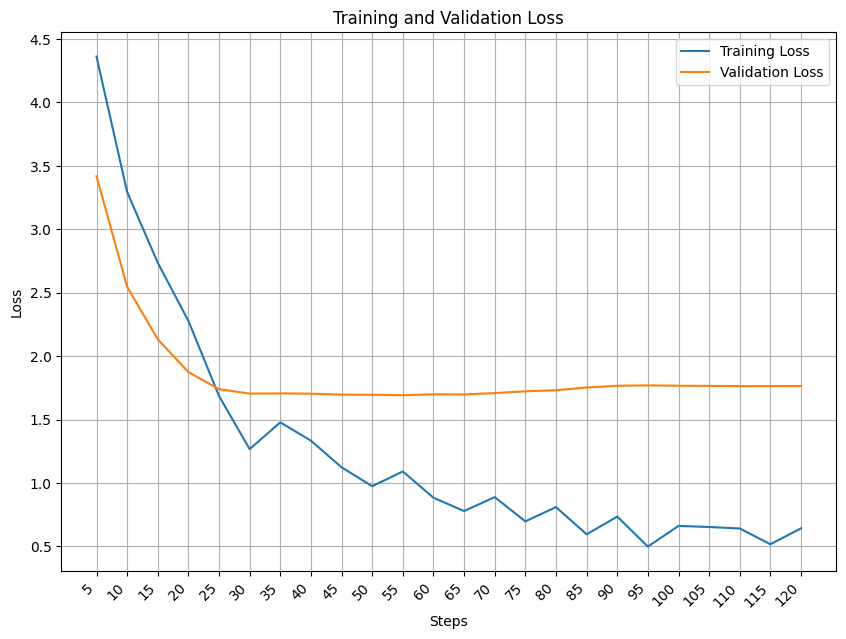

In [127]:

# Extract the logs for training and evaluation losses
logs = trainer.state.log_history

# Separate training and evaluation losses
train_losses = [log['loss'] for log in logs if 'loss' in log]
eval_losses = [log['eval_loss'] for log in logs if 'eval_loss' in log]
steps = [log['step'] for log in logs if 'loss' in log]

# Plot the training and evaluation losses
plt.figure(figsize=(10, 7))
plt.plot(steps, train_losses, label="Training Loss")
plt.plot(steps, eval_losses[:len(train_losses)], label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.grid(True)
plt.xticks(steps, rotation=45, ha="right")
plt.legend()
plt.show()



## Loading the model

In [77]:

def load_model_and_tokenizer(checkpoint_path, takenizer_path):
    # Load the fine-tuned model and tokenizer from the checkpoint
    tokenizer = GPT2Tokenizer.from_pretrained(takenizer_path)
    model = GPT2LMHeadModel.from_pretrained(checkpoint_path)
    return tokenizer, model

def generate_prediction(input_text, tokenizer, model, max_length=50):
    # Encode the input text
    inputs = tokenizer.encode(input_text, return_tensors="pt")

    # Generate prediction
    outputs = model.generate(inputs,
                             max_length=max_length,
                             num_return_sequences=1,
                             pad_token_id=tokenizer.eos_token_id)

    # Decode and return the generated text
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Example usage
checkpoint_path = "/content/gpt2-finetuned/checkpoint-60"  # Path to the fine-tuned model checkpoint
takenizer_path = "./gpt2-finetuned"

# Load the model and tokenizer
tokenizer, model = load_model_and_tokenizer(checkpoint_path, takenizer_path)



## Getting predictions

In [78]:
# Generate prediction
input_text = "The weather today is dark with a dark cloudes"

prediction = generate_prediction(input_text, tokenizer, model)
print(prediction)

The weather today is dark with a dark cloudes. ->: 
Weather forecast: cloudy <STOP> <STOP> <STOP> <STOP> <STOP> <STOP> <STOP> <STOP


## Geting steaming predictions  

In [94]:

# Define the stopping criteria function
def stop_generation(input_ids, scores):
    # Iterate through each batch
    for batch_id in range(len(input_ids)):
        # Decode tokens for the current batch
        decoded_tokens = tokenizer.decode(input_ids[batch_id].tolist())

        # Check if '' is present in the decoded tokens
        if '<STOP>' in decoded_tokens:
            return True  # Stop generation if '' is generated in any batch
    return False  # Continue generation otherwise

def stream(user_prompt):
    runtimeFlag = "cpu"  # Change to CPU

    prompt = f"{user_prompt}"

    inputs = tokenizer([prompt], return_tensors="pt").to(runtimeFlag)

    streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

    # Create a stopping criteria list with the defined function
    stopping_criteria = StoppingCriteriaList()
    stopping_criteria.append(stop_generation)

    # Call the generate method while passing the stopping criteria
    stream_out = model.generate(
        **inputs,
        streamer=streamer,
        max_new_tokens=512,
        stopping_criteria=stopping_criteria,
        do_sample=True,
        top_k=1,
        pad_token_id=tokenizer.eos_token_id
    )


In [98]:
stream("The weather today is sunny with a slight breeze")

. ->: 
Weather forecast: sunny <STOP>


END